In [2]:
from datetime import datetime

import torch

import util
from Dimploma.EnvironmentTree import EnvMinimalTreeTwoStep, EnvMinimalTreeTwoStepRew
from Dimploma.ppo_parallel_custom import Agent
from Dimploma.utils.graph_provider import GraphProvider
from zNetwork.model_global import HybridNetworkGlobal

In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


device:  cpu
Loading graph


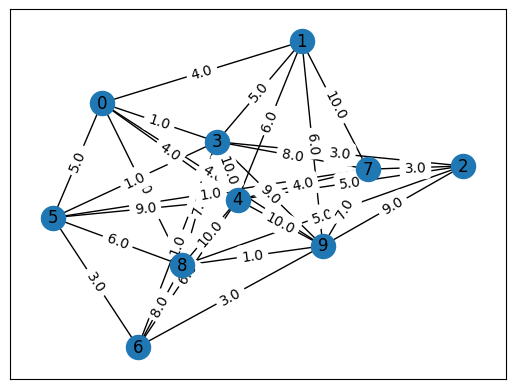

Name: n10_e33_hyb_new_rew
Desc: 
Training comment:
Trying to test out new rewards from EnvMinimalTreeTwoStepRew

Trying out training with:

Training
Iterations: 1000
Epochs: 10
Batch size: 64
Steps amount: 18
On device: cpu
with early stopping

Environment:
Class: EnvMinimalTreeTwoStepRew
Loaded graph from graphs/graph40_n10_e33_hyb_new_rew.pt
Node amount: 10
Edge amount: 33
Node features: 2
With indexes in nodes


Parameters:
Gamma: 0.99
Epsilon: 0.3
Coef_value: 0.5
Coef_Entropy: 0.001
Gae_lambda: 0.95
Learning rate: 0.00025

tensor([[0, 0, 8, 9, 1, 1, 0, 8, 3, 5, 9, 6, 6, 4, 3, 9, 0, 5, 3, 3, 3, 0, 1, 4,
         6, 9, 7, 2, 7, 3, 4, 4, 3],
        [8, 9, 6, 1, 3, 7, 5, 4, 2, 8, 2, 9, 4, 0, 9, 8, 3, 7, 7, 4, 6, 1, 4, 2,
         5, 4, 2, 8, 9, 8, 7, 5, 5]]) 
 tensor([[ 0.5000,  0.0000,  5.0000],
        [ 0.4000,  0.0000,  4.0000],
        [ 0.8000,  0.0000,  8.0000],
        [ 0.6000,  0.0000,  6.0000],
        [ 0.5000,  0.0000,  5.0000],
        [ 1.0000,  0.0000, 10.0000],
      

In [11]:
node_amount = 10
max_edge_amount = torch.sum(torch.arange(node_amount)).item()
edge_amount = int(max_edge_amount*0.75)
iteration_amount = 1000
epoch_amount = 10
batch_size = 64
node_features = 2  # (index, {0,1} selected or not)
steps_amount = int((node_amount - 1)*2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('device: ', device)

new_rewards = True

early_stop = True
position = False
remove_index = False
if position:
    node_features += 2
if remove_index:
    node_features -= 1


gamma=0.99
epsilon=0.3
coef_value=0.5
coef_entropy=0.001
gae_lambda=0.95
lr=0.00025


fixed_graph = True
# load_graph = 'results/min_tree_ppo/node/241217_15#n10_e45_cat_part2/graph.pt'
# load_graph = 'graphs/graph2_norm.pt'
# load_graph = 'graphs/graph5_n50_norm.pt'
load_graph = 'graphs/graph40_n10_e33_hyb_new_rew.pt'
# load_graph = ''
save_new = ''
# save_new = f'graphs/graph40_n{node_amount}_e{edge_amount}_hyb_new_rew.pt'
# load_from = 'results/min_tree_ppo/node/241217_15#n10_e45_cat_part2/models/iter_499_last.pt'
# load_from = 'results/min_tree_ppo/node/250103_18#n10_e45_not_fixed/models/iter_999_last.pt'
load_from = ''
graph = None

if load_graph != '':
    print('Loading graph')
    graph = torch.load(load_graph)
    util.show_data(graph)
elif fixed_graph:
    print('Fixing graph')
    graph = util.generate_random_graph_add_method(node_amount, edge_amount, device=device, position=position)
    if save_new != '':
        print('Saving graph')
        torch.save(graph, save_new)
    util.show_data(graph)

graph_provider = GraphProvider(fixed_graph=graph, device=device, nodes=node_amount, edges=edge_amount, position=position)


name = f'n{node_amount}_e{edge_amount}_hyb_new_rew'

training_desc = f'''
Training comment:
Trying to test out new rewards from EnvMinimalTreeTwoStepRew

Trying out training with:

Training
Iterations: {iteration_amount}
Epochs: {epoch_amount}
Batch size: {batch_size}
Steps amount: {steps_amount}
On device: {device}
{'with' if early_stop else 'without'} early stopping

Environment:
Class: {f'EnvMinimalTreeTwoStepRew' if new_rewards else f'EnvMinimalTreeTwoStep'}
{f'Loaded graph from {load_graph}' if load_graph != '' else 'Fixed graph' + (f' saved  as {save_new}' if save_new != '' else '') if fixed_graph else f'Random generated graphs'}
Node amount: {node_amount}
Edge amount: {edge_amount}
Node features: {node_features}
{'Without indexes in nodes' if remove_index else 'With indexes in nodes'}
{'With positions' if position else ''}

Parameters:
Gamma: {gamma}
Epsilon: {epsilon}
Coef_value: {coef_value}
Coef_Entropy: {coef_entropy}
Gae_lambda: {gae_lambda}
Learning rate: {lr}
'''

path = 'results/min_tree_ppo/node/'
last_path = f'models/iter_{iteration_amount - 1}_last.pt'
print("Name:", name)
print("Desc:", training_desc)
if fixed_graph:
    print(graph.edge_index, '\n', graph.edge_attr, '\n', graph.edge_weight, '\n', graph.x)

In [12]:
last_name = "fuckup"

In [13]:
start_date = datetime.now()

try:
    # noinspection PyUnresolvedReferences
    if last_name == name:
        raise Exception("You should change the name :D")
except NameError:
    raise Exception("You should init last name :D")

if training_desc == '':
    raise Exception("You should write a nice description :D")

last_name = name

net = HybridNetworkGlobal(node_features, node_amount, remove_index, position)

print(f'Agent {name}')

agent = Agent(model=net, gamma=gamma, epsilon=epsilon, coef_value=coef_value, coef_entropy=coef_entropy, gae_lambda=gae_lambda, lr=lr, device=device, path=path, name=name, override=True, early_stop=early_stop)
# agent = Agent(model=net, device=device, path=path, name=name, override=True)

if load_from != '':
    agent.load_model(load_from)

agent.training_description(training_desc)
training_desc = ''
# agent.train([device, None, node_amount, edge_amount], EnvMinimalTreeTwoStep, node_amount, count_of_processes=1, count_of_envs=1, batch_size=32, count_of_iterations=iteration_amount)
agent.train([graph_provider], EnvMinimalTreeTwoStepRew if new_rewards else EnvMinimalTreeTwoStep, node_amount, count_of_iterations=iteration_amount, count_of_epochs=epoch_amount, batch_size=batch_size, count_of_steps=steps_amount)


end_date = datetime.now()
torch.save(graph, agent.path + '/graph.pt')
s = (end_date - start_date).seconds
hours, remainder = divmod(s, 3600)
minutes, seconds = divmod(remainder, 60)
#-1.42077
print(f'Time training {int(hours):02}:{int(minutes):02}:{int(seconds):02}')

Agent n10_e33_hyb_new_rew
Training is starting
Iteration 0 starting
Iteration 0	episode 32	avg score 7.51809	best score 8.21053	best avg score 7.51809
Writing to early val: 7.5180921052631575
Iteration 1 starting
Iteration 1	episode 64	avg score 7.52385	best score 8.21053	best avg score 7.52385
Iteration 2 starting
Iteration 2	episode 96	avg score 7.52632	best score 8.26316	best avg score 7.52632
Iteration 3 starting
Iteration 3	episode 128	avg score 7.44737	best score 8.26316	best avg score 7.52632
Iteration 4 starting
Iteration 4	episode 160	avg score 7.43474	best score 8.26316	best avg score 7.52632
Iteration 5 starting
Iteration 5	episode 192	avg score 7.40526	best score 8.26316	best avg score 7.52632
Iteration 6 starting
Iteration 6	episode 224	avg score 7.47526	best score 8.36842	best avg score 7.52632
Iteration 7 starting
Iteration 7	episode 256	avg score 7.49000	best score 8.36842	best avg score 7.52632
Iteration 8 starting
Iteration 8	episode 288	avg score 7.52947	best score 8